In [1]:
%matplotlib inline

import collections
import random
import socket
import struct
import time
import subprocess

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal

import scapy.layers.tftp as tftp
from scapy.layers.inet import UDP
from scapy.layers.inet6 import IPv6

import sigmf

plt.rcParams['figure.figsize'] = (7, 3.5)

In [2]:
def crc8(data):
    reg = 0
    for d in data:
        for j in range(8):
            b = (d >> (7 - j)) & 1
            feed = (reg >> 7) ^ b
            reg = (reg << 1) & 0xff
            if feed:
                reg ^= 0b1101_0101
    return reg

In [3]:
symbol_rate = 1e6
kbch = 32208 # r = 1/2
dfl = kbch - 80  # 80 bits is BBHEADER size
numslots = 360  # QPSK
numsymbols = numslots * 90 + 90  # PLHEADER is 90 symbols
ts_rate = dfl / (numsymbols / symbol_rate)
ts_rate

988858.1101877502

In [4]:
hex((188 + 0*2 + 0*1) * 8)

'0x5e0'

In [5]:
hex(dfl)

'0x7d80'

In [6]:
hex(0b1100)

'0xc'

In [7]:
# fixed part of BBHEADER
# to append: SYNCD (2 bytes) and CRC-8
bbheader = bytes.fromhex('c20005e07d8047')

# complete BBHEADER (3rd stream)
bbheader2 = bytes.fromhex('c20205e0e30047')

In [8]:
file = 'tftp/gr-dvbgse.tar.xz'
blksize = 1432
file_data = np.fromfile(file, 'uint8')
file_blocks = []
for j in range(0, file_data.size, blksize):
    file_blocks.append(bytes(file_data[j:][:blksize]))

In [9]:
server_ip = 'fe80::1'
client_ip = 'fe80::2'
server_port = 27339
client_port = 41943
tftp_packet = IPv6(src=server_ip, dst=client_ip) / UDP(sport=server_port, dport=client_port) / tftp.TFTP()
ip_packets = []
ip_packets.append(tftp_packet
            / tftp.TFTP_OACK() / tftp.TFTP_Options(options=[
                tftp.TFTP_Option(oname=b'blksize', value=bytes(str(blksize), encoding='ascii')),
                tftp.TFTP_Option(oname=b'tsize', value=bytes(str(file_data.size), encoding='ascii'))]))
for j, block in enumerate(file_blocks):
    ip_packets.append(tftp_packet / tftp.TFTP_DATA(block=j+1) / block)

In [10]:
gse_packets = []
protocol_type = struct.pack('>H', 0x86DD)  # ipv6
for ip_packet in ip_packets:
    ip_packet = bytes(ip_packet)
    gse_length = 2 + len(ip_packet)
    gse_packet = struct.pack('>H', gse_length | (0b1110 << 12)) + protocol_type + ip_packet
    gse_packets.append(gse_packet)

gse_bbframes = []
gse_frames_per_bbframe = 2
for j in range(0, len(gse_packets), gse_frames_per_bbframe):
    packets = b''.join(gse_packets[j:][:gse_frames_per_bbframe])
    gse_dfl = len(packets) * 8
    bbh = bytes.fromhex('42010000') + struct.pack('>H', gse_dfl) + bytes.fromhex('000000')
    bbh = bbh + struct.pack('>B', crc8(bbh))
    padding_len = (dfl - gse_dfl) // 8
    gse_bbframes.append(bbh + packets + b'\x00' * padding_len)

In [11]:
len(gse_bbframes)

30

In [12]:
ts = np.fromfile('frames/output.ts', dtype = 'uint8').reshape(-1,188)
ts.shape

(39478, 188)

In [13]:
ts_bbframes = []
data_field = b''
syncd = 0
up_crc = 0
dnp = 0
npd_every = 30
npd_count = 0
for up in ts:
    up_pid = up[1:3].view('uint16').byteswap() & 0x1fff
    if up_pid == 8191:
        npd_count += 1
        if npd_count % npd_every == 0:
            # delete null packet
            continue
    up = struct.pack('>B', up_crc) + bytes(up[1:])
    #issy = struct.pack('>H', iscr_val & 0x7fff)
    #dnp_enc = struct.pack('>B', dnp)
    #up = up + issy + dnp_enc
    up_crc = crc8(up[1:])
    n = min(dfl//8 - len(data_field), len(up))
    data_field = data_field + up[:n]
    if len(data_field) == dfl//8:
        header = bbheader + struct.pack('>H', syncd)
        header = header + struct.pack('>B', crc8(header))
        bbframe = header + data_field
        ts_bbframes.append(bbframe)
        data_field = up[n:]
        syncd = len(data_field) * 8

In [14]:
random.seed(42)
insertion_points = sorted(random.sample(range(len(ts_bbframes) // 10, len(ts_bbframes) - 10), len(gse_bbframes)))
bbframes = []
k = 0
for j, b in enumerate(ts_bbframes):
    if j in insertion_points:
        bbframes.append(gse_bbframes[k])
        k += 1
    bbframes.append(b)

In [15]:
with open('bbframes.u8', 'wb') as f:
    for b in bbframes:
        f.write(b)

In [16]:
subprocess.run(['/usr/bin/python3', 'dvbs2_encode.py'])

vmcircbuf_sysconfig :info: Using gr::vmcircbuf_sysv_shm_factory


CompletedProcess(args=['/usr/bin/python3', 'dvbs2_encode.py'], returncode=0)

In [17]:
plframes = np.fromfile('qpsk12_plframes.c64', 'complex64').reshape(-1, 2 * numsymbols)
assert plframes.shape[0] == len(bbframes)

In [18]:
kbch2 = 58192 # r = 9/10
dfl2 = kbch2 - 80  # 80 bits is BBHEADER size
numslots2 = 240  # QPSK
numsymbols2 = numslots2 * 90 + 90  # PLHEADER is 90 symbols

In [19]:
flag10_text = np.fromfile('flag10.txt', 'uint8')
flag10_text = np.tile(flag10_text, 5500//flag10_text.size)

In [20]:
flag10_ts = []
j = 0
seq = 0
nullpacket = bytes.fromhex('471fff10') + b'\xff' * 184
while len((remain := flag10_text[j:])) >= 184:
    flag10_ts.append(b'G\x0e\x2b' + struct.pack('>B', seq | (1 << 4)) + bytes(flag10_text[j:][:184]))
    flag10_ts.extend([nullpacket] * np.random.randint(3))
    j += 184
    seq = (seq + 1) & 0xf

In [21]:
ts2_bbframes = []
data_field = b''
syncd = 0
up_crc = 0
for up in flag10_ts:
    up = struct.pack('>B', up_crc) + bytes(up[1:])
    up_crc = crc8(up[1:])
    n = min(dfl2//8 - len(data_field), len(up))
    data_field = data_field + up[:n]
    if len(data_field) == dfl2//8:
        header = bbheader2 + struct.pack('>H', syncd)
        header = header + struct.pack('>B', crc8(header))
        bbframe = header + data_field
        ts2_bbframes.append(bbframe)
        data_field = up[n:]
        syncd = len(data_field) * 8

In [22]:
with open('flag10.ts', 'wb') as f:
    f.write(b''.join(flag10_ts))

with open('bbframes_8psk.u8', 'wb') as f:
    for b in ts2_bbframes:
        f.write(b)

In [23]:
subprocess.run(['/usr/bin/python3', 'dvbs2_encode_8psk.py'])

vmcircbuf_sysconfig :info: Using gr::vmcircbuf_sysv_shm_factory


CompletedProcess(args=['/usr/bin/python3', 'dvbs2_encode_8psk.py'], returncode=0)

In [24]:
plframes2 = np.fromfile('8psk910_plframes.c64', 'complex64').reshape(-1, 2 * numsymbols2)
assert plframes2.shape[0] == len(ts2_bbframes)

In [25]:
cut_point = plframes.shape[0] // 2
with open('plframes_all.c64', 'wb') as f:
    plframes[:cut_point].tofile(f)
    plframes2.tofile(f)
    plframes[-cut_point:].tofile(f)

In [26]:
(plframes.size + plframes2.size)//2 / symbol_rate

59.96574

In [27]:
subprocess.run(['/usr/bin/python3', 'dvbs2_iqfile.py'])

vmcircbuf_sysconfig :info: Using gr::vmcircbuf_sysv_shm_factory


CompletedProcess(args=['/usr/bin/python3', 'dvbs2_iqfile.py'], returncode=0)

In [28]:
# create the metadata
meta = sigmf.SigMFFile(
    data_file='dvbs2.sigmf-data', # extension is optional
    global_info = {
        sigmf.SigMFFile.DATATYPE_KEY: 'ci8',  # in this case, 'cf32_le'
        sigmf.SigMFFile.SAMPLE_RATE_KEY: 2_000_000,
        sigmf.SigMFFile.AUTHOR_KEY: 'Daniel Estévez <daniel@destevez.net>',
        sigmf.SigMFFile.DESCRIPTION_KEY: 'GNU Radio Conference 2023 CTF DVB-S2 challenge',
        sigmf.SigMFFile.VERSION_KEY: sigmf.__version__,
    }
)

# create a capture key at time index 0
meta.add_capture(0, metadata={
    sigmf.SigMFFile.FREQUENCY_KEY: 11723_000_000,
    sigmf.SigMFFile.DATETIME_KEY: '2023-09-05T03:45:00Z',
})

# check for mistakes & write to disk
meta.tofile('dvbs2.sigmf-meta') # extension is optional

In [29]:
sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
for bb in bbframes:
    sock.sendto(bb, ('127.0.0.1', 5000))
    time.sleep(0.001)

In [30]:
# sync byte 71 = 0x47
np.unique(ts[:, 0])

array([71], dtype=uint8)

In [31]:
# TEI = 0
np.unique(ts[:, 1] >> 7)

array([0], dtype=uint8)

In [32]:
pusi = (ts[:, 1] >> 6) & 1
# priority = 0
np.unique((ts[:, 1] >> 5) & 1)

array([0], dtype=uint8)

In [33]:
pid = ts[:, 1:3].ravel().view('uint16').byteswap() & 0x1fff
collections.Counter(pid)

Counter({8191: 21014,
         256: 13200,
         257: 3046,
         0: 601,
         4096: 601,
         258: 591,
         260: 195,
         17: 120,
         259: 110})

In [34]:
# non-null fraction
np.average(pid != 8191)

0.46770353108060186

In [35]:
# TSC = 0
np.unique(ts[:, 3] >> 6)

array([0], dtype=uint8)

In [36]:
adaptation = (ts[:, 3] >> 4) & 0x3
collections.Counter(zip(pid, adaptation))

Counter({(8191, 1): 21014,
         (256, 1): 9459,
         (257, 1): 2662,
         (256, 3): 2581,
         (256, 2): 1160,
         (0, 1): 600,
         (4096, 1): 600,
         (257, 3): 384,
         (258, 3): 330,
         (258, 1): 261,
         (260, 1): 177,
         (17, 1): 119,
         (259, 1): 92,
         (259, 3): 18,
         (260, 3): 18,
         (17, 3): 1,
         (0, 3): 1,
         (4096, 3): 1})

In [37]:
continuity = ts[:, 3] & 0xf

In [38]:
[(p, np.unique(np.diff(continuity[pid == p]) % 16 - 1)) for p in set(pid)]

[(0, array([0], dtype=uint8)),
 (4096, array([0], dtype=uint8)),
 (256, array([  0, 255], dtype=uint8)),
 (259, array([0], dtype=uint8)),
 (260, array([0], dtype=uint8)),
 (257, array([0], dtype=uint8)),
 (258, array([0], dtype=uint8)),
 (17, array([0], dtype=uint8)),
 (8191, array([255], dtype=uint8))]

In [39]:
adaptation[pid == 256]

array([3, 1, 1, ..., 2, 2, 2], dtype=uint8)

In [40]:
sel = (pid == 256) & (adaptation == 3)
adaptation_length = ts[sel][:, 4]
sel2 = adaptation_length > 0
discontinuity = ts[sel][sel2][:, 5] >> 7
random_access = (ts[sel][sel2][:, 5] >> 6) & 1
es_priority = (ts[sel][sel2][:, 5] >> 5) & 1
pcr_flag = (ts[sel][sel2][:, 5] >> 4) & 1
opcr_flag = (ts[sel][sel2][:, 5] >> 3) & 1
splicing_point_flag = (ts[sel][sel2][:, 5] >> 2) & 1
transport_private_data_flag = (ts[sel][sel2][:, 5] >> 1) & 1
extension_flag = ts[sel][sel2][:, 5] & 1

In [41]:
pcr_data = ts[sel][sel2][pcr_flag == 1][:, 6:12]
pcr = (((pcr_data[:, :4].ravel().view('uint32').byteswap().astype('int') << 1) | (pcr_data[:, 4] >> 7)) * 300 
    + (((pcr_data[:, -2] & 1).astype('int') << 8) | pcr_data[:, -1].astype('int'))
      ) / 27e6
pcr_idx = np.arange(ts.shape[0])[sel][sel2][pcr_flag == 1] * 8 * 188

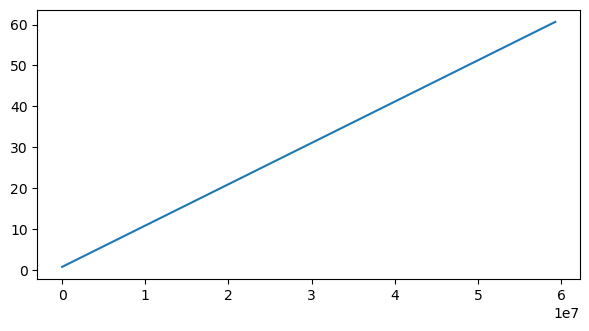

In [42]:
plt.plot(pcr_idx, pcr)

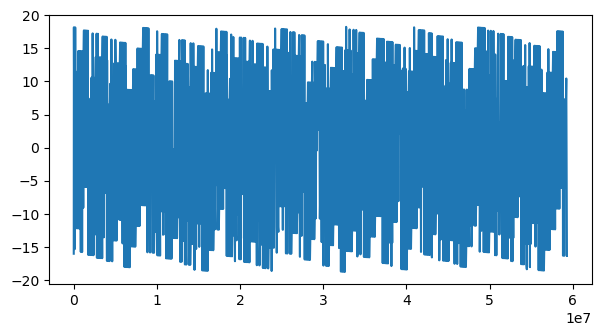

In [43]:
p = np.polyfit(pcr_idx, pcr, 1)
plt.plot(pcr_idx, 1e9 * (pcr - np.polyval(p, pcr_idx)))

In [44]:
1 / p[0]

988857.9999967015